# Plot all FastCalo shower shapes

This notebook is dedicated to produce some plots to fastcalo instroduction (cut-based studies)

**NOTE**: This notebook presents only mc15 plots.

In [1]:
from ProfileTools import profiles
from Gaugi import load
from Gaugi.monet.utils import getColor
from Gaugi.monet.PlotFunctions import *
from Gaugi.monet.TAxisFunctions import *
from Gaugi.monet.AtlasStyle import *
from ROOT import TCanvas, TH1F
from ROOT import kRed, kBlue, kBlack,TLine,kBird, kOrange,kGray, kYellow, kViolet, kGreen, kAzure
from pprint import pprint
import array
import numpy as np
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2
SetAtlasStyle()
GeV=1000.

Welcome to JupyROOT 6.23/01
Using all sub packages with ROOT dependence

Applying ATLAS style settings...


In [2]:
etbins = [15, 20, 30, 40, 50, 1000000]
etabins = [0.0, 0.8, 1.37, 1.54, 2.37, 2.50]

In [3]:
path = '/Volumes/castor/cern_data/files/Zee/mc15_13TeV.sgn.probes_lhmedium_Zee.bkg.Truth.JF17/'
path+= 'mc15_13TeV.sgn.probes_lhmedium_Zee.bkg.Truth.JF17_et{ET}_eta{ETA}.npz'
paths = [[ path.format(ET=et,ETA=eta) for eta in range(5)] for et in range(5)]  

In [4]:
def merge_data( paths ):
    data = None
    features = None
    target = None
    for et in range(5):
        for eta in range(5):
            raw = load(paths[et][eta])
            if data is None:
                data = raw['data']
                target = raw['target']
                features = raw['features']
            else:
                data = np.concatenate((data, raw['data']),axis=0)
                target = np.concatenate((target, raw['target']),axis=0)
    return data, target, features

data,target,features = merge_data(paths)

In [5]:
data.shape

(2259583, 154)

In [6]:
features = features.tolist()

In [7]:
et = data[:, features.index('L2Calo_et')]
eta = data[:, features.index('L2Calo_eta')]
pt = data[:, features.index('L2Electron_pt')]
has_track = data[:, features.index('L2Electron_hastrack')]

## Get all L2Calo shapes:

Get all events higher than 22 GeV inside of the first eta bin (0.0 < |eta| < 0.6)

### Eratio:

In [8]:
eratio_sgn = data[np.where((target==1) & (et>25*GeV) & (abs(eta) < 0.6)), features.index('L2Calo_eratio')].flatten()

In [9]:
eratio_bkg = data[np.where((target!=1) & (et>25*GeV) & (abs(eta) < 0.6)), features.index('L2Calo_eratio')].flatten()

### Reta:

In [10]:
reta_sgn = data[np.where((target==1) & (et>25*GeV) & (abs(eta) < 0.6)), features.index('L2Calo_reta')].flatten()

In [11]:
reta_bkg = data[np.where((target!=1) & (et>25*GeV) & (abs(eta) < 0.6)), features.index('L2Calo_reta')].flatten()

### EThad/ETem

In [12]:
et_sgn = data[np.where((target==1) & (et>25*GeV) & (abs(eta) < 0.6)), features.index('L2Calo_et')].flatten()
eta_sgn = data[np.where((target==1) & (et>25*GeV) & (abs(eta) < 0.6)), features.index('L2Calo_eta')].flatten()
ehad1_sgn = data[np.where((target==1) & (et>25*GeV) & (abs(eta) < 0.6)), features.index('L2Calo_ehad1')].flatten()
ethad_sgn = ehad1_sgn/np.cosh(np.abs(eta_sgn))
rhad_sgn = ethad_sgn/et_sgn

In [13]:
et_bkg = data[np.where((target!=1) & (et>25*GeV) & (abs(eta) < 0.6)), features.index('L2Calo_et')].flatten()
eta_bkg = data[np.where((target!=1) & (et>25*GeV) & (abs(eta) < 0.6)), features.index('L2Calo_eta')].flatten()
ehad1_bkg = data[np.where((target!=1) & (et>25*GeV) & (abs(eta) < 0.6)), features.index('L2Calo_ehad1')].flatten()
ethad_bkg = ehad1_bkg/np.cosh(np.abs(eta_bkg))
rhad_bkg = ethad_bkg/et_bkg

## Get cuts:

In [14]:
from TrigEgammaEmulationTool.TrigEgammaL2CaloHypoCuts import L2CaloCutMaps
cuts = L2CaloCutMaps(25)
print(cuts.MapsCAERATIOthr.keys())

dict_keys(['vloose', 'loose', 'lhvloose', 'lhloose', 'medium', 'lhmedium', 'tight', 'lhtight', 'mergedtight'])


## Let's plot some L2Calo showers:

In [15]:
def AddLegend(canvas, x, y, legends):
    MakeLegend( canvas,x,y,x+0.98,y+0.20,textsize=16, names=legends, option = 'f' )

In [16]:
def CreateHist(values, name, bins, xmin, xmax):
    h = TH1F(name, "", bins, xmin, xmax)
    w = array.array( 'd', np.ones_like(values) )
    h.FillN( len(values), array.array('d',  values.tolist()),  w)
    return h

In [17]:
def AddThreshold(canvas, value , ymin, ymax, color=1, width=1, offset=0.1 ):
    from ROOT import TLine, TArrow
    line = TLine(value,ymin,value,ymax)
    line.SetNDC(False)
    line.SetLineColor(color)
    line.SetLineWidth(width)
    line.Draw()
    arrow = TArrow(value,ymax,value+offset,ymax,0.01,"|>");
    arrow.SetNDC(False)
    arrow.Draw()
    arrow.SetLineWidth(width)
    arrow.SetLineColor(color)
    canvas.Modified()
    canvas.Update()
    return line, arrow

In [18]:
def PlotHist( values_sgn, values_bkg , xlabel, bins, xmin, xmax , y_axis_maximum=None):
    from Gaugi.monet.utils import NormHist
    
    h_sgn = CreateHist(values_sgn, 'sgn', bins, xmin, xmax)
    h_bkg = CreateHist(values_bkg, 'bkg', bins, xmin, xmax)
    # Create canvas
    canvas = TCanvas('canvas','canvas',700, 500)
    h_sgn = NormHist(h_sgn)
    h_bkg = NormHist(h_bkg)
    h_sgn.SetLineColor(kAzure)
    h_sgn.SetFillColor(kAzure-4)
    h_bkg.SetLineColor(kRed)
    h_bkg.SetFillColor(getColor(kRed, 0.5))
    if y_axis_maximum:
        h_sgn.SetMaximum(y_axis_maximum)
        h_bkg.SetMaximum(y_axis_maximum)
    AddHistogram(canvas,h_sgn, 'same')
    AddHistogram(canvas,h_bkg, 'same')
    FormatCanvasAxes(canvas, XLabelSize=16, YLabelSize=16, XTitleOffset=0.87, ZLabelSize=16,
                             ZTitleSize=16, YTitleOffset=1.10, ZTitleOffset=1.1)
    SetAxisLabels(canvas,xlabel, 'counts/bin (norm by counts)')
    return canvas

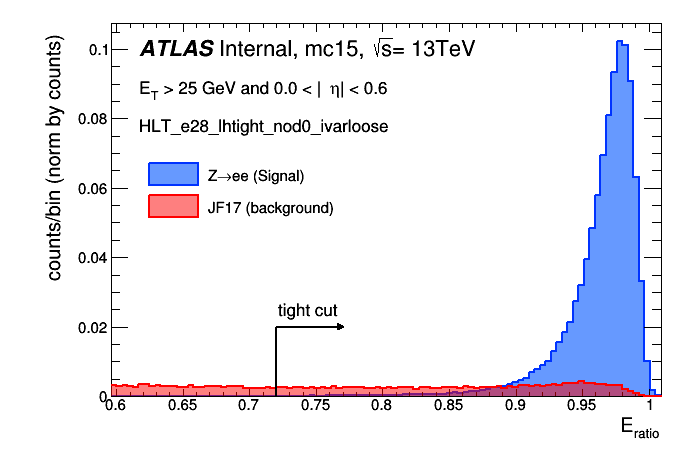

In [19]:
canvas = PlotHist(eratio_sgn, eratio_bkg, 'E_{ratio}', 100, 0.6, 1.005)
AddATLASLabel(canvas, 0.2, 0.88, 'Internal, mc15, #sqrt{s}= 13TeV')
thr_tight = cuts.MapsCAERATIOthr['tight'][0]
AddLegend( canvas,0.2,0.53, ['Z#rightarrowee (Signal)', 'JF17 (background)'])
l1 = AddThreshold(canvas, thr_tight, 0, 0.02, width=2, offset=0.05)
AddTexLabel(canvas, 0.4, 0.33, 'tight cut', textsize=0.04)
AddTexLabel(canvas, 0.2, 0.8, 'E_{T} > 25 GeV and 0.0 < |#eta| < 0.6', textsize=0.04)
AddTexLabel(canvas, 0.2, 0.72, 'HLT_e28_lhtight_nod0_ivarloose', textsize=0.04)
canvas.Draw()
canvas.SaveAs('L2Calo_eratio.pdf')

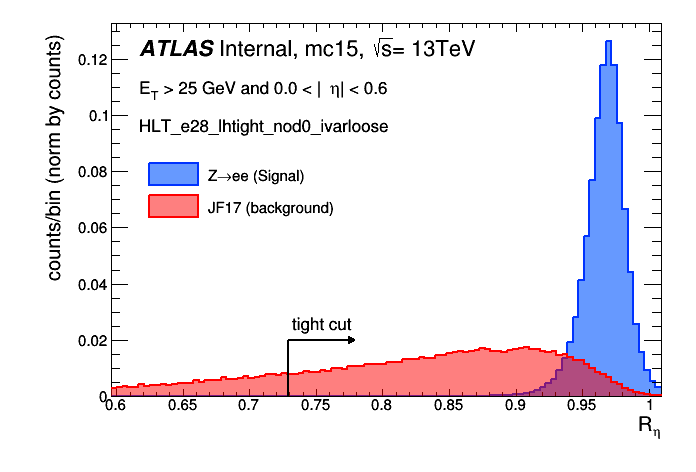

In [20]:
canvas = PlotHist(reta_sgn, reta_bkg, 'R_{#eta}', 100, 0.6, 1.005)
AddATLASLabel(canvas, 0.2, 0.88, 'Internal, mc15, #sqrt{s}= 13TeV')
thr_tight = cuts.MapsCARCOREthr['tight'][0]
AddLegend( canvas,0.2,0.53, ['Z#rightarrowee (Signal)', 'JF17 (background)'])
l1 = AddThreshold(canvas, thr_tight, 0, 0.02, width=2, offset=0.05)
AddTexLabel(canvas, 0.42, 0.3, 'tight cut', textsize=0.04)
AddTexLabel(canvas, 0.2, 0.8, 'E_{T} > 25 GeV and 0.0 < |#eta| < 0.6', textsize=0.04)
AddTexLabel(canvas, 0.2, 0.72, 'HLT_e28_lhtight_nod0_ivarloose', textsize=0.04)
canvas.Draw()
canvas.SaveAs('L2Calo_reta.pdf')

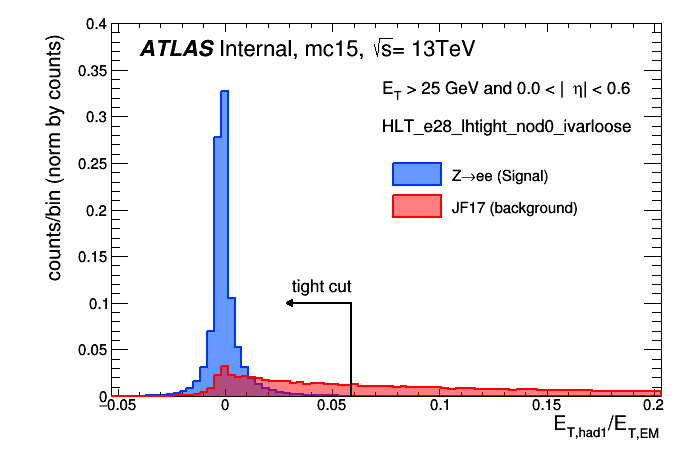

In [21]:
canvas = PlotHist(rhad_sgn, rhad_bkg, 'E_{T,had1}/E_{T,EM}', 80, -0.05, 0.2, 0.4)
AddATLASLabel(canvas, 0.2, 0.88, 'Internal, mc15, #sqrt{s}= 13TeV')
thr_tight = cuts.MapsHADETthr['tight'][0]
AddLegend( canvas,0.55,0.53, ['Z#rightarrowee (Signal)', 'JF17 (background)'])
l1 = AddThreshold(canvas, thr_tight, 0, 0.1, width=2, offset=-0.03)
AddTexLabel(canvas, 0.42, 0.38, 'tight cut', textsize=0.04)
AddTexLabel(canvas, 0.55, 0.8, 'E_{T} > 25 GeV and 0.0 < |#eta| < 0.6', textsize=0.04)
AddTexLabel(canvas, 0.55, 0.72, 'HLT_e28_lhtight_nod0_ivarloose', textsize=0.04)
canvas.Draw()
canvas.SaveAs('L2Calo_rhad.pdf')